# Classifying names with RNN
### Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory

In [1]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
from tqdm import tqdm_notebook as tq
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [4]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8983, -2.8679, -2.9328, -2.9722, -2.9292, -2.9289, -2.8842, -2.8772,
         -2.8967, -2.8880, -2.9275, -2.8418, -2.8708, -2.8986, -2.8024, -2.9640,
         -2.8538, -2.8110]], grad_fn=<LogSoftmaxBackward>)


In [11]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Russian', 14)


In [12]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Kappel
category = Chinese / line = Loh
category = French / line = Simon
category = Irish / line = O'Reilly
category = Irish / line = O'Callaghann
category = Dutch / line = Penders
category = Polish / line = Sowka
category = Czech / line = Bastl
category = Italian / line = Leggieri
category = Russian / line = Baderskov


### Training the network

In [13]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [14]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in tq(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.4691 Takenouchi / Russian ✗ (Japanese)
10000 10% (0m 18s) 2.0973 Shamoon / Irish ✗ (Arabic)
15000 15% (0m 28s) 1.3656 Fernandes / Portuguese ✓
20000 20% (0m 37s) 2.7913 Koenig / Russian ✗ (German)
25000 25% (0m 46s) 0.0956 Nagasawa / Japanese ✓
30000 30% (0m 55s) 1.6980 Jirovy / Czech ✓
35000 35% (1m 4s) 3.3409 Bellamy / Irish ✗ (French)
40000 40% (1m 13s) 1.9735 Sokal / Czech ✗ (Polish)
45000 45% (1m 22s) 2.3596 Hunter / German ✗ (Scottish)
50000 50% (1m 31s) 0.8998 Ri / Korean ✓
55000 55% (1m 41s) 0.3723 Madeira / Portuguese ✓
60000 60% (1m 50s) 1.3197 Cha / Vietnamese ✗ (Korean)
65000 65% (1m 59s) 0.4571 Madeira / Portuguese ✓
70000 70% (2m 8s) 0.7876 Schmitz / German ✓
75000 75% (2m 18s) 2.1626 Hetherington / Russian ✗ (English)
80000 80% (2m 28s) 1.8659 Muir / German ✗ (Scottish)
85000 85% (2m 37s) 0.1254 Ukhovsky / Russian ✓
90000 90% (2m 47s) 2.5954 Pitterman / German ✗ (Czech)
95000 95% (2m 57s) 0.1844 O'Doherty / Irish ✓
100000 100% (3m 7s) 0.4494 Kanaan / Ar

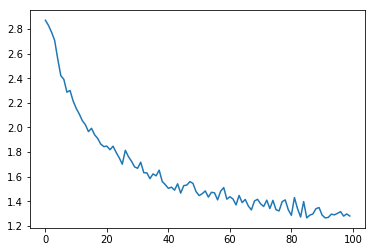

In [15]:
plt.figure()
plt.plot(all_losses)

### Evaluating the results

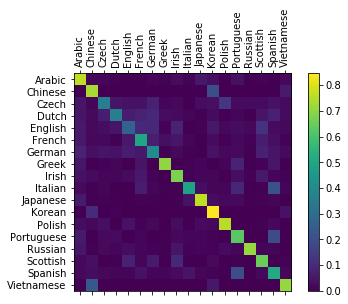

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.61) Russian
(-1.18) Czech
(-2.75) English

> Jackson
(-0.20) Scottish
(-2.54) English
(-2.80) Russian

> Satoshi
(-0.65) Arabic
(-1.53) Japanese
(-2.92) Portuguese
